In [96]:
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [97]:
def encode_dataset (data , target_column):
    """
    Encodes dataset by separating features and labels, and converting labels to integers.
    Args:
        data: List of lists containing the dataset
        target_column: Index of the target colum  
    Returns:
        X: Feature matrix (numpy array)
        y: Encoded labels (numpy array)
        label_encoding: Dictionary mapping original labels to encoded integers
    """

    features = []
    labels = []

    for row in data:
        feature_row = row[:target_column]+row[target_column+1:]
        features.append(feature_row)
        labels.append(row[target_column])

    unique_labels = sorted(list(set(labels)))
    label_encoding = {label : i for i, label in enumerate(unique_labels)} # creates a dictionary of labels and their integer encoding
    y = np.array([label_encoding[label] for label in labels])
    X = np.array(features, dtype='float64')

    return X , y , label_encoding


In [98]:
def gini_impurity (labels):
    """
    Calculates Gini impurity for a set of labels.
    Args:
        labels: Array of class labels   
    Returns:
        Gini impurity value (float)
    """

    from collections import Counter
    total = len(labels)
    frequency_mapping = Counter(labels)
    
    sum = 0
    for label in frequency_mapping:
        sum = sum+((frequency_mapping[label]/total)**2)

    gini_value = 1-sum
    return gini_value

In [99]:
def finding_best_split(X , y):
    """
    Finds the best feature and threshold to split the data using Gini impurity
    Args:
        X: Feature matrix
        y: Target labels 
    Returns:
        best_feature_index: Index of best feature to split on
        best_threshold: Best threshold value for splitting
    """
    best_gini = float('inf')
    best_feature_index = None
    best_threshold = None

    n_samples, n_features = X.shape
    for index in range(n_features):
        feature = X[: , index]
        len_feature = len(feature)

        sorted_indices = np.argsort(feature)
        sorted_feature = feature[sorted_indices]
        sorted_labels = y[sorted_indices]

        for i in range(len_feature-1):

            threshold = (sorted_feature[i]+sorted_feature[i+1])/2
            set_one = sorted_labels[:i+1] # length is i+1
            set_two = sorted_labels[i+1:] # length is len(feature)-i-1

            net_gini_value = ((i+1)/len_feature)*gini_impurity(set_one)+((len_feature-i-1)/len_feature)*gini_impurity(set_two)
            if net_gini_value<best_gini:
                best_gini = net_gini_value
                best_threshold = threshold
                best_feature_index = index

    return best_feature_index, best_threshold


In [100]:
class Node:
    '''
    implementation of the node class
    '''
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, value=None):
        
        self.feature_index = feature_index  #stores the feature index for the splitting
        self.threshold = threshold  #the threshold value for the feature          
        self.left = left  #left subtree                  
        self.right = right  #right subtree              
        self.value = value  #final value of the node (only in case of leaf nodes)               

def build_tree (X , y , depth=0 , max_depth = 10 , min_sample_split = 2):
    """
    Recursively builds decision tree.
    Args:
        X: Feature matrix
        y: Target labels
        depth: Current depth of tree
        max_depth: Maximum allowed depth
        min_sample_split: Minimum samples required to split   
    Returns:
        Node: Root node of the tree/subtree
    """

    if len(y) == 0:
        return None
    
    if len(set(y)) == 1:
        return Node(value=y[0])

    if len(y) < min_sample_split:
        if len(y) == 0:
            return None
        majority_class = Counter(y).most_common(1)[0][0]
        return Node(value=majority_class)

    if depth >= max_depth:
        majority_class = Counter(y).most_common(1)[0][0]
        return Node(value=majority_class)

    if X.shape[0] == 0:
        return None
    
    feature_index , threshold = finding_best_split(X , y)
    if feature_index is None:
        # No valid split found (can happen with small or pure data)
        majority_class = Counter(y).most_common(1)[0][0]
        return Node(value=majority_class)
    
    left_section_indices = X[: , feature_index] <= threshold
    right_section_indices = X[: , feature_index] > threshold

    left_subtree = build_tree(X[left_section_indices] , y[left_section_indices] , depth+1 , max_depth , min_sample_split)
    right_subtree = build_tree(X[right_section_indices] , y[right_section_indices], depth+1 , max_depth , min_sample_split)

    return Node(
        feature_index=feature_index,
        threshold=threshold,
        left=left_subtree,
        right=right_subtree,
        value=None
    )           

In [101]:
def implementing_prediction(node, new_value):
    if node.value is not None:
        return node.value
        
    if new_value[node.feature_index] <= node.threshold:
        return implementing_prediction(node.left, new_value)
    else:
        return implementing_prediction(node.right, new_value)

In [102]:
data = [
    [12.0, 1.5, 1, 'Wine'],
    [5.0, 2.0, 0, 'Beer'],
    [40.0, 0.0, 1, 'Whiskey'],
    [13.5, 1.2, 1, 'Wine'],
    [4.5, 1.8, 0, 'Beer'],
    [38.0, 0.1, 1, 'Whiskey'],
    [11.5, 1.7, 1, 'Wine'],
    [5.5, 2.3, 0, 'Beer']
]

X , y , label_encoding = encode_dataset(data , 3)
head_node = build_tree(X ,y)

'''
Final working of the model on given test data
'''
test_data = np.array([
    [6.0, 2.1, 0],   # Expected: Beer (0)
    [39.0, 0.05, 1],  # Expected: Whiskey (1)
    [13.0, 1.3, 1]    # Expected: Wine (2)
])

for sample in test_data:
    pred = implementing_prediction(head_node, sample)
    if pred == 0:
        prediction = "Beer"
    elif pred == 1:
        prediction = "Whiskey"
    elif pred == 2:
        prediction = "Wine"

    print(f"Sample {sample} → Predicted: {prediction}")

Sample [6.  2.1 0. ] → Predicted: Beer
Sample [39.    0.05  1.  ] → Predicted: Whiskey
Sample [13.   1.3  1. ] → Predicted: Wine


<Figure size 1000x600 with 0 Axes>

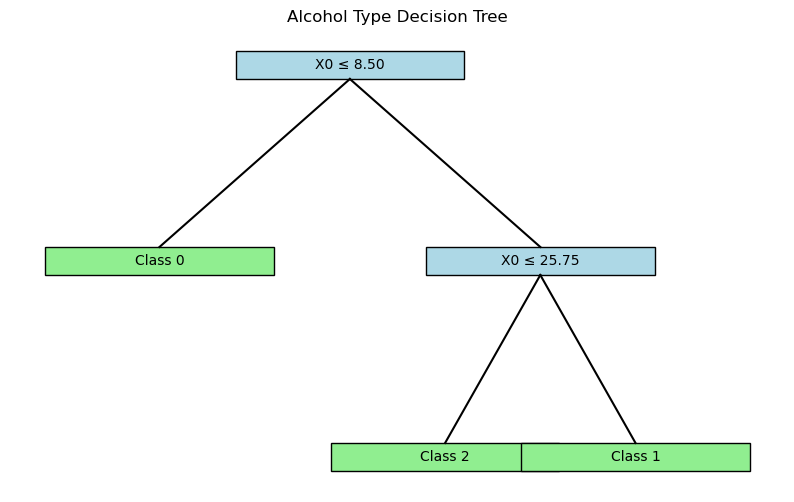

In [103]:
# Written by ChatGPT :))))

def plot_tree(node, x=0, y=0, width=1, depth=1, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.set_axis_off()
    
    node_width = 0.3
    node_height = 0.1
    vertical_spacing = 0.7
    
    # Draw current node
    if node.value is not None:
        # Leaf node
        label = f"Class {node.value}"
        color = 'lightgreen'
    else:
        # Decision node
        label = f"X{node.feature_index} ≤ {node.threshold:.2f}"
        color = 'lightblue'
    
    ax.add_patch(Rectangle((x - node_width/2, y - node_height/2), 
                         node_width, node_height, 
                         facecolor=color, edgecolor='black'))
    ax.text(x, y, label, ha='center', va='center')
    
    # Recursively plot children
    if node.left is not None:
        left_x = x - width/4
        left_y = y - vertical_spacing
        ax.plot([x, left_x], [y - node_height/2, left_y + node_height/2], 'k-')
        plot_tree(node.left, left_x, left_y, width/2, depth+1, ax)
    
    if node.right is not None:
        right_x = x + width/4
        right_y = y - vertical_spacing
        ax.plot([x, right_x], [y - node_height/2, right_y + node_height/2], 'k-')
        plot_tree(node.right, right_x, right_y, width/2, depth+1, ax)
    
    ax.autoscale_view()
    return ax

# Visualize the tree
plt.figure(figsize=(10, 6))
plot_tree(head_node)
plt.title("Alcohol Type Decision Tree")
plt.show()
